In [1]:
%pylab inline
import matplotlib.pyplot as pl
from astropy.io import fits
import numpy as np

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
decade_dir='/project2/chihway/data/decade/'
File_list = ['DES1213-3457', 'DES1224-3749', 'DES1225-4206', 'DES1318-3623', 'DES1319-3457']

In [88]:
i=2
infile = fits.open(decade_dir+File_list[i]+'_cat.fits')
print(infile[1].header.keys)

<bound method Header.keys of XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                 1224 / width of table in bytes                        
NAXIS2  =                68473 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                  158 / number of fields in each row                   
TTYPE1  = 'COADD_OBJECT_ID'    / label for field   1                            
TFORM1  = 'K       '           / data format of field: 8-byte INTEGER           
TTYPE2  = 'RA      '           / label for field   2                            
TFORM2  = 'D       '           / data format of field: 8-byte DOUBLE            

In [89]:
full_data = infile[1].data
mask_SEflag = (full_data['FLAGS_G']<=3)*(full_data['FLAGS_R']<=3)*(full_data['FLAGS_I']<=3)*(full_data['FLAGS_Z']<=3)
mask_IMAflag = (full_data['IMAFLAGS_ISO_G']==0)*(full_data['IMAFLAGS_ISO_R']==0)*(full_data['IMAFLAGS_ISO_I']==0)*(full_data['IMAFLAGS_ISO_Z']==0)
extend_coadd = np.array(((full_data['SPREAD_MODEL_I']+3*full_data['SPREADERR_MODEL_I'])>0.005))*1 + np.array((full_data['SPREAD_MODEL_I']+full_data['SPREADERR_MODEL_I'])>0.003) *1 + np.array((full_data['SPREAD_MODEL_I']-full_data['SPREADERR_MODEL_I'])>0.002)*1
mask_extend = (extend_coadd>=2)
SNR_R = full_data['FLUX_AUTO_R']/full_data['FLUXERR_AUTO_R']
mask_snr = (SNR_R>5)
size_R = full_data['FLUX_RADIUS_R']*0.236
mask_size = (size_R>0.7)


/tmp/ipykernel_46897/952457261.py:6: RuntimeWarning: invalid value encountered in true_divide
  SNR_R = full_data['FLUX_AUTO_R']/full_data['FLUXERR_AUTO_R']


In [90]:
area = 0.73*0.73*60*60
print('original', len(infile[1].data), len(infile[1].data)/area)
print('SE flags', len(infile[1].data[mask_SEflag]), len(infile[1].data[mask_SEflag])/area)
print('IMA_ISO flags', len(infile[1].data[mask_SEflag*mask_IMAflag]),len(infile[1].data[mask_SEflag*mask_IMAflag])/area)
print('extend_class flags', len(infile[1].data[mask_SEflag*mask_IMAflag*mask_extend]), len(infile[1].data[mask_SEflag*mask_IMAflag*mask_extend])/area)
print('SNR cut', len(infile[1].data[mask_SEflag*mask_IMAflag*mask_extend*mask_snr]), len(infile[1].data[mask_SEflag*mask_IMAflag*mask_extend*mask_snr])/area)
print('size cut', len(infile[1].data[mask_SEflag*mask_IMAflag*mask_extend*mask_snr*mask_size]), len(infile[1].data[mask_SEflag*mask_IMAflag*mask_extend*mask_snr*mask_size])/area)





original 68473 35.6920206000709
SE flags 66844 34.84289318404537
IMA_ISO flags 63481 33.08990638226893
extend_class flags 22249 11.597443756385397
SNR cut 15808 8.240028356372887
size cut 11959 6.233710723296012


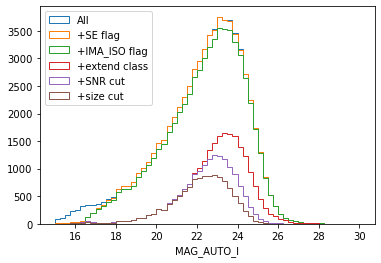

In [91]:
pl.hist(full_data['MAG_AUTO_I'], range=(15,30), bins=60, histtype='step', label='All')
pl.hist(full_data['MAG_AUTO_I'][mask_SEflag], range=(15,30), bins=60, histtype='step', label='+SE flag')
pl.hist(full_data['MAG_AUTO_I'][mask_SEflag*mask_IMAflag], range=(15,30), bins=60, histtype='step', label='+IMA_ISO flag')
pl.hist(full_data['MAG_AUTO_I'][mask_SEflag*mask_IMAflag*mask_extend], range=(15,30), bins=60, histtype='step', label='+extend class')
pl.hist(full_data['MAG_AUTO_I'][mask_SEflag*mask_IMAflag*mask_extend*mask_snr], range=(15,30), bins=60, histtype='step', label='+SNR cut')
pl.hist(full_data['MAG_AUTO_I'][mask_SEflag*mask_IMAflag*mask_extend*mask_snr*mask_size], range=(15,30), bins=60, histtype='step', label='+size cut')
pl.xlabel('MAG_AUTO_I')
pl.legend(loc=2)



In [92]:
# save coadd IDs

Text(0, 0.5, 'SPREAD_MODEL_I')

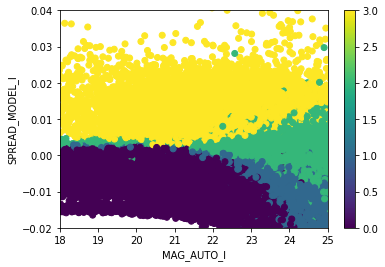

In [93]:
pl.scatter(full_data['MAG_AUTO_I'], full_data['SPREAD_MODEL_I'], c=extend_coadd)
pl.xlim(18,25)
pl.ylim(-0.02,0.04)
pl.colorbar()
pl.xlabel('MAG_AUTO_I')
pl.ylabel('SPREAD_MODEL_I')

Text(0, 0.5, 'SPREAD_MODEL_I')

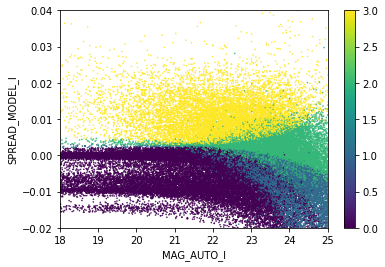

In [94]:
pl.scatter(full_data['MAG_AUTO_I'][mask_SEflag*mask_IMAflag], full_data['SPREAD_MODEL_I'][mask_SEflag*mask_IMAflag], c=extend_coadd[mask_SEflag*mask_IMAflag],s=0.3)
pl.xlim(18,25)
pl.ylim(-0.02,0.04)
pl.colorbar()
pl.xlabel('MAG_AUTO_I')
pl.ylabel('SPREAD_MODEL_I')